In [43]:
#ensembling
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression

### Define static parameters for data

In [22]:
dir_name='reparse'
docs_map_name = 'scaled.binary.5_stop_docs_map.json'
crf_params_name='.802_21.07_07:26_best_params.json'
per_par=True
seq_len=3
step=3
test_doc_num = 8
n_splits = 10
seed=42
cv_db = pd.DataFrame()

### Define test documents

In [23]:
imp.reload(model_utils)
x=np.arange(1,81)
cv_splits=model_utils.get_test_train_splits(x,test_doc_num,n_splits,seed)
cv_splits

{0: {'test': array([ 4, 14, 15, 18, 29, 32, 36, 70]),
  'train': array([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 16, 17, 19, 20, 21,
         22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41,
         42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
         59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76,
         77, 78, 79, 80])},
 1: {'test': array([ 5,  6, 13, 34, 37, 62, 73, 80]),
  'train': array([ 1,  2,  3,  4,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
         21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39,
         40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
         57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75,
         76, 77, 78, 79])},
 2: {'test': array([ 7, 20, 39, 47, 48, 54, 57, 58]),
  'train': array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3

In [26]:
imp.reload(common_utils)
# cv_splits
# common_utils.save_json(cv_splits,dir_name,"cv_splits_10")
cv_splits_loaded=common_utils.load_json(cv_splits,dir_name,"cv_splits_10")
cv_splits_loaded
cv_splits

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_splits_10.json


{0: {'test': array([ 4, 14, 15, 18, 29, 32, 36, 70]),
  'train': array([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 16, 17, 19, 20, 21,
         22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41,
         42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
         59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76,
         77, 78, 79, 80])},
 1: {'test': array([ 5,  6, 13, 34, 37, 62, 73, 80]),
  'train': array([ 1,  2,  3,  4,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,
         21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39,
         40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
         57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75,
         76, 77, 78, 79])},
 2: {'test': array([ 7, 20, 39, 47, 48, 54, 57, 58]),
  'train': array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3

### Load docs_map

In [27]:
imp.reload(common_utils)
docs_map=common_utils.get_docs_map(dir_name,docs_map_name,per_par,seq_len,step)

In [28]:
docs_map[1].keys()

dict_keys(['X_3_3', 'y_3_3', 'groups_3_3', 'X_bert', 'y_bert'])

### Cross-validate CRF

#### Load best CRF params

In [29]:
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,crf_params_name)
with open(json_path,'r') as fp:
    best_params_crf = json.load(fp)
best_params_crf

{'c1': 0.5850178031143265, 'c2': 0.052554161623508414, 'min_freq': 3}

In [30]:
imp.reload(model_utils)
cv_db_crf=model_utils.prepared_cross_validate_crf(cv_db,docs_map, cv_splits, seq_len=3, step=3,**best_params_crf)

0 split started...
0 split fit took 00:00:14
0 split predict took 00:00:00
1 split started...
1 split fit took 00:00:13
1 split predict took 00:00:00
2 split started...
2 split fit took 00:00:12
2 split predict took 00:00:00
3 split started...
3 split fit took 00:00:13
3 split predict took 00:00:00
4 split started...
4 split fit took 00:00:14
4 split predict took 00:00:00
5 split started...
5 split fit took 00:00:15
5 split predict took 00:00:00
6 split started...
6 split fit took 00:00:16
6 split predict took 00:00:00
7 split started...
7 split fit took 00:00:15
7 split predict took 00:00:00
8 split started...
8 split fit took 00:00:15
8 split predict took 00:00:00
9 split started...
9 split fit took 00:00:15
9 split predict took 00:00:00


In [31]:
cv_db_crf

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1
0,4,0,not_nar,not_nar,0.958612,0.041388
1,4,0,not_nar,not_nar,0.972640,0.027360
2,4,0,not_nar,not_nar,0.984728,0.015272
3,4,0,is_nar,not_nar,0.712459,0.287541
4,4,0,is_nar,not_nar,0.684794,0.315206
...,...,...,...,...,...,...
38776,79,9,not_nar,not_nar,0.969380,0.030620
38777,79,9,not_nar,not_nar,0.992972,0.007028
38778,79,9,not_nar,not_nar,0.993904,0.006096
38779,79,9,not_nar,not_nar,0.989410,0.010590


In [32]:
cv_db_crf['crf_group'].unique()

array([ 4, 14, 15, 18, 29, 32, 36, 70,  5,  6, 13, 34, 37, 62, 73, 80,  7,
       20, 39, 47, 48, 54, 57, 58,  1, 19, 24, 27, 44, 56, 71, 75, 12, 21,
       26, 33, 41, 50, 76, 77,  8, 11, 16, 40, 51, 53, 63, 72,  9, 25, 30,
       38, 49, 55, 59, 74,  3, 10, 28, 31, 42, 45, 66, 68,  2, 23, 43, 46,
       61, 65, 67, 69, 17, 22, 35, 52, 60, 64, 78, 79])

Split 0
              precision    recall  f1-score   support

      is_nar       0.69      0.58      0.63       781
     not_nar       0.88      0.92      0.90      2597

    accuracy                           0.84      3378
   macro avg       0.78      0.75      0.76      3378
weighted avg       0.83      0.84      0.84      3378

Split 1
              precision    recall  f1-score   support

      is_nar       0.58      0.30      0.40      1045
     not_nar       0.79      0.92      0.85      2911

    accuracy                           0.76      3956
   macro avg       0.68      0.61      0.62      3956
weighted avg       0.73      0.76      0.73      3956

Split 2
              precision    recall  f1-score   support

      is_nar       0.63      0.40      0.49       915
     not_nar       0.81      0.91      0.86      2498

    accuracy                           0.77      3413
   macro avg       0.72      0.66      0.67      3413
weighted avg       0.76      0.77      0.76      3

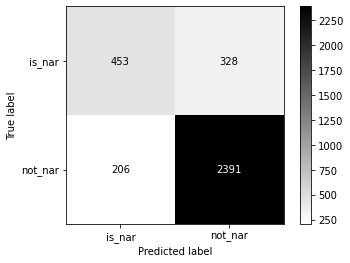

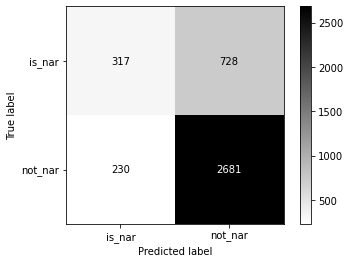

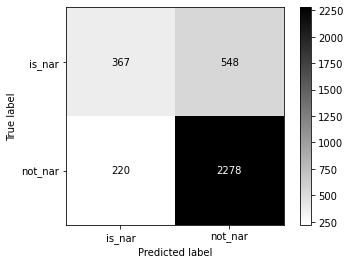

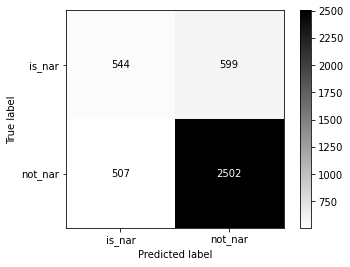

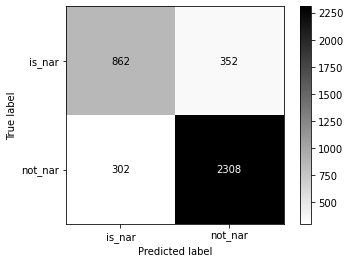

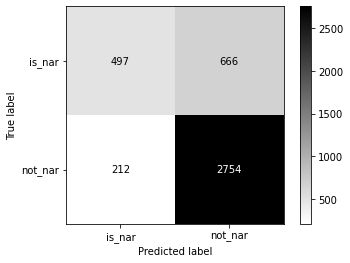

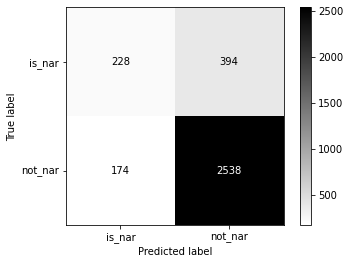

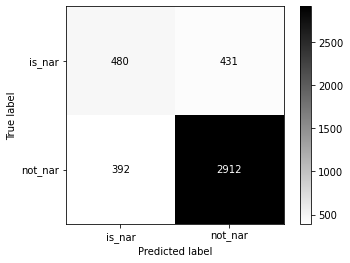

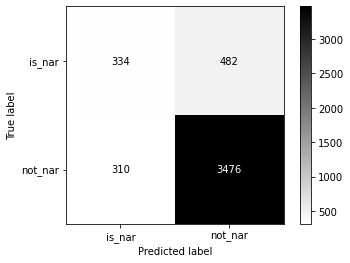

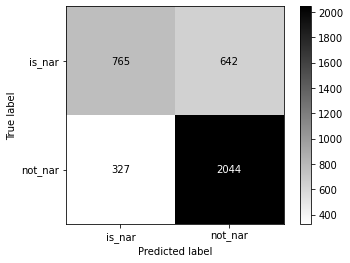

In [33]:
imp.reload(model_utils)
model_utils.get_report_from_splits(cv_db_crf,"crf")

In [34]:
common_utils.save_db(cv_db_crf,dir_name,"cv_crf_all")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_crf_all.csv,  index False


### Cross-validate BERT

In [17]:
dir_name

'reparse'

In [13]:
imp.reload(common_utils)
imp.reload(my_bert)
cv_db_bert=my_bert.prepared_cross_validate_bert(cv_db_=bert_cv,
                                                docs_map=docs_map,
                                                cv_splits={0:{'train': np.array([1,2]), 'test':np.array([3,4])},
                                                          1: {'train': np.array([5,6]), 'test':np.array([7,8])}},
                                                epoch=2,
                                                batch_size=512,
                                                dir_name=dir_name)

BertXYTransformer>>>>>>>init() called
0 split started...
BertXYTransformer>>>>>>>transform() called for 2 docs
y labels are
 BertXYTransformer>>>>>>>transform() done for 1265 samples, labels are [0. 1.]
BertXYTransformer>>>>>>>transform() called for 2 docs
y labels are
 BertXYTransformer>>>>>>>transform() done for 1153 samples, labels are [0. 1.]


Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.67358892 1.94018405]

 Epoch 1 / 2

Evaluating...
Saving best model bert

Training Loss: 0.705

Validation Loss: 0.700

 Epoch 2 / 2

Evaluating...
Saving best model bert

Training Loss: 0.688

Validation Loss: 0.690
0 split train_validate took 00:01:22
Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/split_0_bert_valid_dict.json
Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert_cv_db_all.csv,  index False
1 split started...
BertXYTransformer>>>>>>>transform() called for 2 docs
y labels are
 BertXYTransformer>>>>>>>transform() done for 1323 samples, labels are [0. 1.]
BertXYTransformer>>>>>>>transform() called for 2 docs
y labels are
 BertXYTransformer>>>>>>>transform() done for 865 samples, labels are [0. 1.]


Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.72216157 1.62530713]

 Epoch 1 / 2

Evaluating...
Saving best model bert

Training Loss: 0.699

Validation Loss: 0.693

 Epoch 2 / 2

Evaluating...
Saving best model bert

Training Loss: 0.687

Validation Loss: 0.685
1 split train_validate took 00:01:15
Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/split_1_bert_valid_dict.json
Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert_cv_db_all.csv,  index False


In [14]:
imp.reload(my_bert)
imp.reload(common_utils)
bert_cv=pd.DataFrame()
cv_db_bert=my_bert.prepared_cross_validate_bert(cv_db_=bert_cv,
                                                docs_map=docs_map,
                                                cv_splits=cv_splits,
                                                epoch=10,
                                                batch_size=512,
                                                dir_name=dir_name)

BertXYTransformer>>>>>>>init() called
0 split started...
BertXYTransformer>>>>>>>transform() called for 72 docs
y labels are
 BertXYTransformer>>>>>>>transform() done for 35403 samples, labels are [0. 1.]
BertXYTransformer>>>>>>>transform() called for 8 docs
y labels are
 BertXYTransformer>>>>>>>transform() done for 3378 samples, labels are [0. 1.]


Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.67648183 1.91657644]

 Epoch 1 / 10
  Batch    50  of     70.

Evaluating...
Saving best model bert

Training Loss: 0.641

Validation Loss: 0.558

 Epoch 2 / 10
  Batch    50  of     70.

Evaluating...
Saving best model bert

Training Loss: 0.592

Validation Loss: 0.551

 Epoch 3 / 10
  Batch    50  of     70.

Evaluating...
Saving best model bert

Training Loss: 0.571

Validation Loss: 0.549

 Epoch 4 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.550

Validation Loss: 0.552

 Epoch 5 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.525

Validation Loss: 0.559

 Epoch 6 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.494

Validation Loss: 0.576

 Epoch 7 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.463

Validation Loss: 0.609

 Epoch 8 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.423

Validatio

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.67351951 1.94076014]

 Epoch 1 / 10
  Batch    50  of     69.

Evaluating...
Saving best model bert

Training Loss: 0.648

Validation Loss: 0.611

 Epoch 2 / 10
  Batch    50  of     69.

Evaluating...
Saving best model bert

Training Loss: 0.581

Validation Loss: 0.597

 Epoch 3 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.558

Validation Loss: 0.601

 Epoch 4 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.532

Validation Loss: 0.617

 Epoch 5 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.504

Validation Loss: 0.639

 Epoch 6 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.473

Validation Loss: 0.672

 Epoch 7 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.440

Validation Loss: 0.707

 Epoch 8 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.420

Validation Loss: 0.754

 Epoch 9

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.67326582 1.9428697 ]

 Epoch 1 / 10
  Batch    50  of     70.

Evaluating...
Saving best model bert

Training Loss: 0.640

Validation Loss: 0.610

 Epoch 2 / 10
  Batch    50  of     70.

Evaluating...
Saving best model bert

Training Loss: 0.588

Validation Loss: 0.604

 Epoch 3 / 10
  Batch    50  of     70.

Evaluating...
Saving best model bert

Training Loss: 0.564

Validation Loss: 0.603

 Epoch 4 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.541

Validation Loss: 0.610

 Epoch 5 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.513

Validation Loss: 0.628

 Epoch 6 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.481

Validation Loss: 0.662

 Epoch 7 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.445

Validation Loss: 0.698

 Epoch 8 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.408

Validatio

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.67227723 1.95114943]

 Epoch 1 / 10
  Batch    50  of     68.

Evaluating...
Saving best model bert

Training Loss: 0.643

Validation Loss: 0.608

 Epoch 2 / 10
  Batch    50  of     68.

Evaluating...
Saving best model bert

Training Loss: 0.587

Validation Loss: 0.590

 Epoch 3 / 10
  Batch    50  of     68.

Evaluating...
Saving best model bert

Training Loss: 0.565

Validation Loss: 0.587

 Epoch 4 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.543

Validation Loss: 0.589

 Epoch 5 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.515

Validation Loss: 0.602

 Epoch 6 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.482

Validation Loss: 0.628

 Epoch 7 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.451

Validation Loss: 0.656

 Epoch 8 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.417

Validatio

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.66829166 1.9855163 ]

 Epoch 1 / 10
  Batch    50  of     69.

Evaluating...
Saving best model bert

Training Loss: 0.642

Validation Loss: 0.596

 Epoch 2 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.594

Validation Loss: 0.599

 Epoch 3 / 10
  Batch    50  of     69.

Evaluating...
Saving best model bert

Training Loss: 0.573

Validation Loss: 0.591

 Epoch 4 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.551

Validation Loss: 0.592

 Epoch 5 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.523

Validation Loss: 0.602

 Epoch 6 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.489

Validation Loss: 0.615

 Epoch 7 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.456

Validation Loss: 0.643

 Epoch 8 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.423

Validation Loss: 0.681

 Epoch 9

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.67160245 1.95685566]

 Epoch 1 / 10
  Batch    50  of     68.

Evaluating...
Saving best model bert

Training Loss: 0.641

Validation Loss: 0.578

 Epoch 2 / 10
  Batch    50  of     68.

Evaluating...
Saving best model bert

Training Loss: 0.589

Validation Loss: 0.566

 Epoch 3 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.564

Validation Loss: 0.570

 Epoch 4 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.541

Validation Loss: 0.584

 Epoch 5 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.513

Validation Loss: 0.602

 Epoch 6 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.482

Validation Loss: 0.619

 Epoch 7 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.449

Validation Loss: 0.656

 Epoch 8 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.414

Validation Loss: 0.710

 Epoch 9

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.68031245 1.88648217]

 Epoch 1 / 10
  Batch    50  of     70.

Evaluating...
Saving best model bert

Training Loss: 0.642

Validation Loss: 0.574

 Epoch 2 / 10
  Batch    50  of     70.

Evaluating...
Saving best model bert

Training Loss: 0.588

Validation Loss: 0.564

 Epoch 3 / 10
  Batch    50  of     70.

Evaluating...
Saving best model bert

Training Loss: 0.568

Validation Loss: 0.561

 Epoch 4 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.545

Validation Loss: 0.564

 Epoch 5 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.521

Validation Loss: 0.569

 Epoch 6 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.489

Validation Loss: 0.585

 Epoch 7 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.459

Validation Loss: 0.606

 Epoch 8 / 10
  Batch    50  of     70.

Evaluating...

Training Loss: 0.428

Validatio

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.67882954 1.89797935]

 Epoch 1 / 10
  Batch    50  of     68.

Evaluating...
Saving best model bert

Training Loss: 0.640

Validation Loss: 0.613

 Epoch 2 / 10
  Batch    50  of     68.

Evaluating...
Saving best model bert

Training Loss: 0.584

Validation Loss: 0.607

 Epoch 3 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.561

Validation Loss: 0.608

 Epoch 4 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.539

Validation Loss: 0.623

 Epoch 5 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.512

Validation Loss: 0.646

 Epoch 6 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.480

Validation Loss: 0.654

 Epoch 7 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.445

Validation Loss: 0.685

 Epoch 8 / 10
  Batch    50  of     68.

Evaluating...

Training Loss: 0.412

Validation Loss: 0.713

 Epoch 9

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.68418208 1.85735246]

 Epoch 1 / 10
  Batch    50  of     67.

Evaluating...
Saving best model bert

Training Loss: 0.639

Validation Loss: 0.620

 Epoch 2 / 10
  Batch    50  of     67.

Evaluating...
Saving best model bert

Training Loss: 0.585

Validation Loss: 0.605

 Epoch 3 / 10
  Batch    50  of     67.

Evaluating...

Training Loss: 0.562

Validation Loss: 0.613

 Epoch 4 / 10
  Batch    50  of     67.

Evaluating...

Training Loss: 0.539

Validation Loss: 0.624

 Epoch 5 / 10
  Batch    50  of     67.

Evaluating...

Training Loss: 0.510

Validation Loss: 0.646

 Epoch 6 / 10
  Batch    50  of     67.

Evaluating...

Training Loss: 0.480

Validation Loss: 0.691

 Epoch 7 / 10
  Batch    50  of     67.

Evaluating...

Training Loss: 0.445

Validation Loss: 0.725

 Epoch 8 / 10
  Batch    50  of     67.

Evaluating...

Training Loss: 0.412

Validation Loss: 0.741

 Epoch 9

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertTrainValidator>>>>>>> init() called
BertTrainValidator>>>>>>> train_validate() called
Class Weights: [0.66311143 2.03269454]

 Epoch 1 / 10
  Batch    50  of     69.

Evaluating...
Saving best model bert

Training Loss: 0.644

Validation Loss: 0.597

 Epoch 2 / 10
  Batch    50  of     69.

Evaluating...
Saving best model bert

Training Loss: 0.592

Validation Loss: 0.589

 Epoch 3 / 10
  Batch    50  of     69.

Evaluating...
Saving best model bert

Training Loss: 0.569

Validation Loss: 0.586

 Epoch 4 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.545

Validation Loss: 0.597

 Epoch 5 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.519

Validation Loss: 0.613

 Epoch 6 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.487

Validation Loss: 0.639

 Epoch 7 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.453

Validation Loss: 0.666

 Epoch 8 / 10
  Batch    50  of     69.

Evaluating...

Training Loss: 0.423

Validatio

In [15]:
cv_db_bert

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1
0,4,0,0,0,0.679904,0.320096
1,4,0,0,0,0.795950,0.204050
2,4,0,0,0,0.846528,0.153472
3,4,0,0,0,0.638051,0.361949
4,4,0,0,0,0.645552,0.354448
...,...,...,...,...,...,...
38776,79,9,0,0,0.797658,0.202342
38777,79,9,0,0,0.884326,0.115675
38778,79,9,0,0,0.889441,0.110559
38779,79,9,0,0,0.880385,0.119615


In [16]:
imp.reload(common_utils)
common_utils.save_db(cv_db_bert,dir_name,"cv_bert_all")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_bert_all.csv,  index False


Split 0
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      2597
           1       0.50      0.56      0.53       781

    accuracy                           0.77      3378
   macro avg       0.68      0.70      0.69      3378
weighted avg       0.78      0.77      0.77      3378

Split 1
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      2911
           1       0.47      0.59      0.52      1045

    accuracy                           0.72      3956
   macro avg       0.65      0.68      0.66      3956
weighted avg       0.74      0.72      0.73      3956

Split 2
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2498
           1       0.54      0.55      0.55       915

    accuracy                           0.76      3413
   macro avg       0.69      0.69      0.69      3413
weighted avg       0.76      0.76      0.76      3

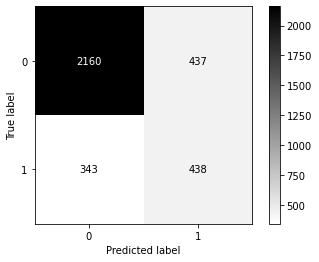

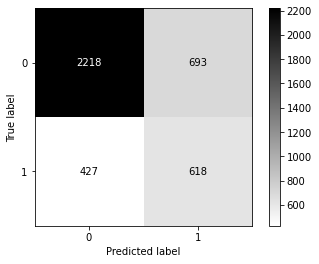

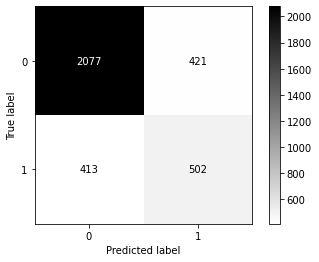

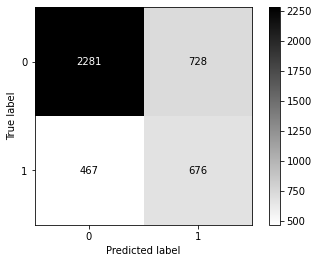

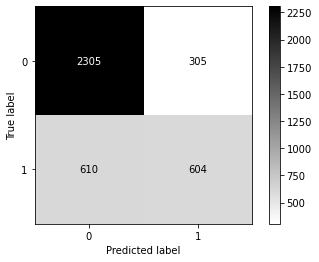

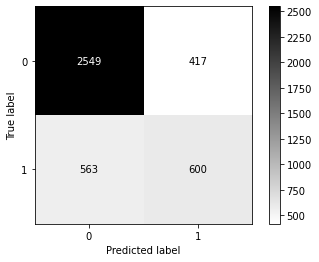

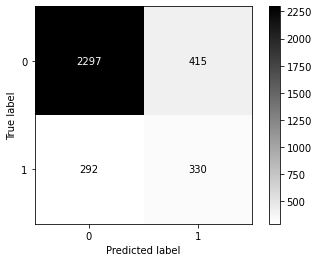

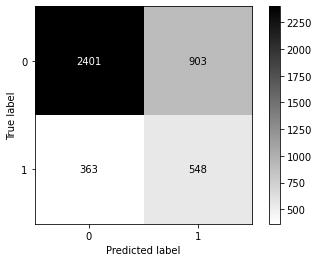

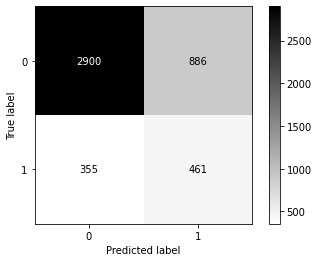

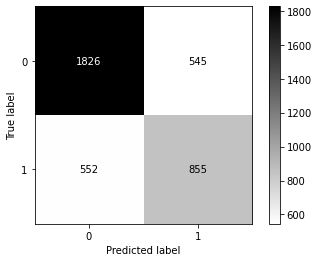

In [17]:
model_utils.get_report_from_splits(cv_db_bert,"bert")

### Merge BERT and CRF predictions

In [35]:
doc_size_db=pd.DataFrame()
doc_size_db['crf']=cv_db_crf.groupby('crf_group').size()
doc_size_db['bert']=cv_db_bert.groupby('bert_group').size()
doc_size_db

,crf,bert
crf_group,,
1,613,613
2,652,652
3,682,682
4,471,471
5,513,513
...,...,...
76,475,475
77,439,439
78,186,186


In [36]:
cv_db_crf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38781 entries, 0 to 38780
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   crf_group      38781 non-null  int64  
 1   crf_split      38781 non-null  int64  
 2   crf_predicted  38781 non-null  object 
 3   crf_true       38781 non-null  object 
 4   crf_proba_0    38781 non-null  float64
 5   crf_proba_1    38781 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.8+ MB


In [37]:
cv_db_bert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38781 entries, 0 to 38780
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bert_group      38781 non-null  int64  
 1   bert_split      38781 non-null  int64  
 2   bert_predicted  38781 non-null  int64  
 3   bert_true       38781 non-null  int64  
 4   bert_proba_0    38781 non-null  float32
 5   bert_proba_1    38781 non-null  float32
dtypes: float32(2), int64(4)
memory usage: 1.5 MB


In [38]:
merged_cv_db=pd.merge(cv_db_crf,cv_db_bert,left_index=True,right_index=True,validate='one_to_one')
merged_cv_db

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1
0,4,0,not_nar,not_nar,0.958612,0.041388,4,0,0,0,0.679904,0.320096
1,4,0,not_nar,not_nar,0.972640,0.027360,4,0,0,0,0.795950,0.204050
2,4,0,not_nar,not_nar,0.984728,0.015272,4,0,0,0,0.846528,0.153472
3,4,0,is_nar,not_nar,0.712459,0.287541,4,0,0,0,0.638051,0.361949
4,4,0,is_nar,not_nar,0.684794,0.315206,4,0,0,0,0.645552,0.354448
...,...,...,...,...,...,...,...,...,...,...,...,...
38776,79,9,not_nar,not_nar,0.969380,0.030620,79,9,0,0,0.797658,0.202342
38777,79,9,not_nar,not_nar,0.992972,0.007028,79,9,0,0,0.884326,0.115675
38778,79,9,not_nar,not_nar,0.993904,0.006096,79,9,0,0,0.889441,0.110559
38779,79,9,not_nar,not_nar,0.989410,0.010590,79,9,0,0,0.880385,0.119615


### Check that merge is correct

In [39]:
neg_label='not_nar'
merged_cv_db.query('crf_true==@neg_label and bert_true==1')

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1


In [40]:
neg_label='not_nar'
merged_cv_db.query('crf_group!=bert_group')

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1


### Run classifier on inputs from BERT and CRF proba

In [173]:
from sklearn.linear_model import LogisticRegression
X_train=merged_cv_db[merged_cv_db['crf_split'].isin([0,1])][['crf_proba_0','crf_proba_1','bert_proba_0','bert_proba_1']]
y_train=merged_cv_db[merged_cv_db['crf_split'].isin([0,1])]['bert_true']
X_test=merged_cv_db[merged_cv_db['crf_split'].isin([2])][['crf_proba_0','crf_proba_1','bert_proba_0','bert_proba_1']]
y_test=merged_cv_db[merged_cv_db['crf_split'].isin([2])]['bert_true']
X_train.head(),y_train.head()

(   crf_proba_0  crf_proba_1  bert_proba_0  bert_proba_1
 0     0.927267     0.072733      0.526763      0.473237
 1     0.970439     0.029561      0.782847      0.217153
 2     0.984975     0.015025      0.791494      0.208506
 3     0.840957     0.159043      0.674561      0.325439
 4     0.860823     0.139177      0.527963      0.472037,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: bert_true, dtype: int64)

In [175]:
lr_clf = LogisticRegression(random_state=0).fit(X_train, y_train)
lr_clf_pred=lr_clf.predict(X_test)

In [176]:
lr_clf.classes_

array([0, 1])

In [178]:
lr_clf.coef_

array([[-1.15513374,  1.14935738, -2.06329758,  2.05752122]])

CRF + BERT Logistic regression
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3321
           1       0.88      0.92      0.90       972

    accuracy                           0.95      4293
   macro avg       0.93      0.94      0.93      4293
weighted avg       0.95      0.95      0.95      4293



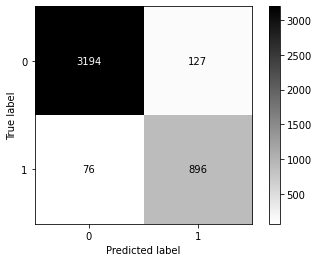

In [177]:
feature_utils.get_prediction_report(y_test,lr_clf_pred,lr_clf.classes_,"CRF + BERT Logistic regression")

### Implement cross-validate on ensemble

### Check what documents included in merged_cv_db

In [335]:
merged_cv_db[merged_cv_db['crf_group'].isin(cv_splits[0]['train'])]

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1
5051,6,1,not_nar,not_nar,0.821621,0.178379,6,1,0,0,0.898004,0.101996
5052,6,1,not_nar,not_nar,0.829427,0.170573,6,1,0,0,0.813328,0.186673
5053,6,1,not_nar,not_nar,0.850742,0.149258,6,1,0,0,0.902851,0.097149
5054,6,1,not_nar,not_nar,0.674174,0.325826,6,1,0,0,0.922566,0.077434
5055,6,1,not_nar,not_nar,0.647519,0.352481,6,1,0,0,0.897437,0.102563
...,...,...,...,...,...,...,...,...,...,...,...,...
14585,77,2,not_nar,not_nar,0.980402,0.019598,77,2,0,0,0.713230,0.286770
14586,77,2,not_nar,not_nar,0.984651,0.015349,77,2,0,0,0.945393,0.054607
14587,77,2,not_nar,not_nar,0.974347,0.025653,77,2,0,0,0.953558,0.046442
14588,77,2,not_nar,not_nar,0.975137,0.024863,77,2,0,0,0.939007,0.060993


In [84]:
merged_cv_db.query('crf_true == "is_nar" and bert_true ==0')

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1


In [85]:
merged_cv_db.query('crf_true == "not_nar" and bert_true == 1')

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1


In [92]:
inp=[1,2,3,4,5,6,7,8,9]
imp.reload(common_utils)
out=common_utils.reshape_to_seq(inp,3,2)
out

[[1, 2, 3], [3, 4, 5], [5, 6, 7], [7, 8, 9], [9]]

In [336]:
merged_cv_db['crf_group'].unique()

array([ 1, 12, 13, 20, 21, 41, 46, 55, 59, 76,  6,  8, 14, 19, 35, 36, 45,
       60, 65, 69, 24, 25, 28, 34, 37, 40, 44, 49, 54, 77])

In [337]:
ensembled_doc_num=len(merged_cv_db['crf_group'].unique())
ensembled_doc_num

30

In [338]:
ensemble_test_percent=0.125
n_splits=3
test_doc_num=int(ensemble_test_percent*ensembled_doc_num)
test_doc_num

3

In [339]:
ensemble_cv=model_utils.get_test_train_splits(merged_cv_db['crf_group'].unique(),test_doc_num,n_splits,seed)
ensemble_cv

{0: {'test': array([ 1, 35, 54]),
  'train': array([12, 13, 20, 21, 41, 46, 55, 59, 76,  6,  8, 14, 19, 36, 45, 60, 65,
         69, 24, 25, 28, 34, 37, 40, 44, 49, 77])},
 1: {'test': array([59, 14, 77]),
  'train': array([ 1, 12, 13, 20, 21, 41, 46, 55, 76,  6,  8, 19, 35, 36, 45, 60, 65,
         69, 24, 25, 28, 34, 37, 40, 44, 49, 54])},
 2: {'test': array([60, 69, 25]),
  'train': array([ 1, 12, 13, 20, 21, 41, 46, 55, 59, 76,  6,  8, 14, 19, 35, 36, 45,
         65, 24, 28, 34, 37, 40, 44, 49, 54, 77])}}

In [343]:
merged_cv_db.head()

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1
0,1,0,not_nar,not_nar,0.927267,0.072733,1,0,0,0,0.526763,0.473237
1,1,0,not_nar,not_nar,0.970439,0.029561,1,0,0,0,0.782847,0.217153
2,1,0,not_nar,not_nar,0.984975,0.015025,1,0,0,0,0.791494,0.208506
3,1,0,not_nar,not_nar,0.840957,0.159043,1,0,0,0,0.674561,0.325439
4,1,0,not_nar,not_nar,0.860823,0.139177,1,0,0,0,0.527963,0.472037


In [240]:
common_utils.save_db(merged_cv_db,dir_name,'cv_crf_bert')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_crf_bert.csv,  index False


### Cross-validate on original splits - ensemble by LogisticRegression

In [93]:
imp.reload(model_utils)
imp.reload(common_utils)
ensemble_cv_db=pd.DataFrame()
ensemble_cv_db=model_utils.prepared_cross_validate_ensemble(LogisticRegression(random_state=0),ensemble_cv_db,merged_cv_db,cv_splits)

0 split started...
train: [ 1  2  3  5  6  7  8  9 10 11 12 13 16 17 19 20 21 22 23 24 25 26 27 28
 30 31 33 34 35 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 71 72 73 74 75 76 77 78 79 80]
test: [ 4 14 15 18 29 32 36 70]
1 split started...
train: [ 1  2  3  4  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 35 36 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 63 64 65 66 67 68 69 70 71 72 74 75 76 77 78 79]
test: [ 5  6 13 34 37 62 73 80]
2 split started...
train: [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 49 50 51 52 53
 55 56 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
test: [ 7 20 39 47 48 54 57 58]
3 split started...
train: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49 50 51 

In [94]:
ensemble_cv_db 

,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true
0,0,0.888815,0.111185,4,0,0
1,0,0.915271,0.084729,4,0,0
2,0,0.926048,0.073952,4,0,0
3,0,0.786277,0.213723,4,0,0
4,0,0.776083,0.223917,4,0,0
...,...,...,...,...,...,...
38776,0,0.920903,0.079097,79,9,0
38777,0,0.938290,0.061710,79,9,0
38778,0,0.939122,0.060878,79,9,0
38779,0,0.937170,0.062830,79,9,0


Split 0
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2597
           1       0.74      0.54      0.62       781

    accuracy                           0.85      3378
   macro avg       0.80      0.74      0.76      3378
weighted avg       0.84      0.85      0.84      3378

Split 1
              precision    recall  f1-score   support

           0       0.80      0.94      0.87      2911
           1       0.68      0.35      0.46      1045

    accuracy                           0.78      3956
   macro avg       0.74      0.65      0.66      3956
weighted avg       0.77      0.78      0.76      3956

Split 2
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2498
           1       0.70      0.35      0.46       915

    accuracy                           0.78      3413
   macro avg       0.75      0.65      0.66      3413
weighted avg       0.77      0.78      0.76      3

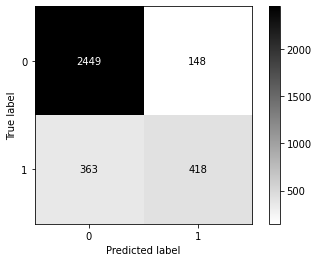

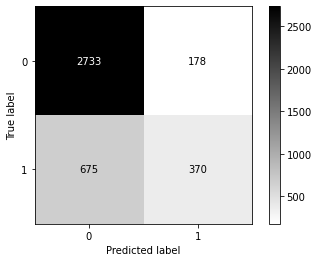

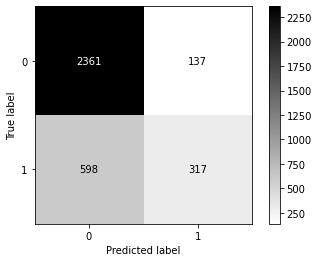

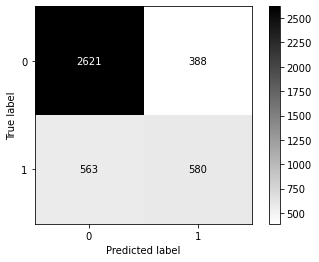

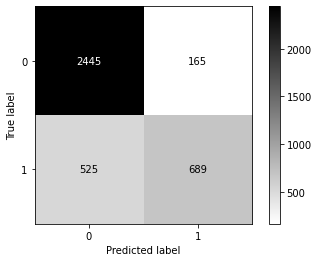

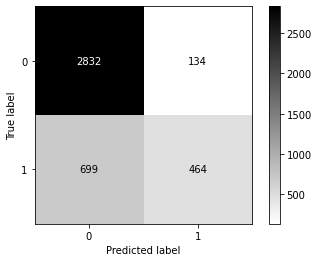

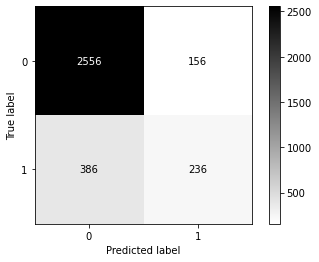

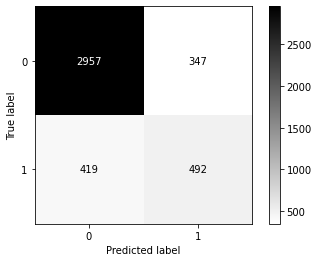

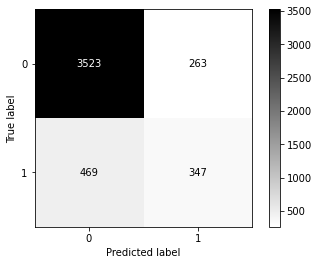

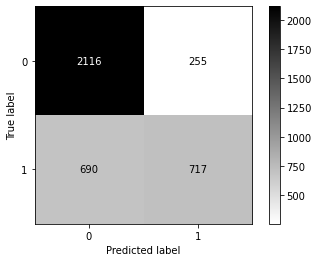

In [95]:
model_utils.get_report_from_splits(ensemble_cv_db,"ens")

### Cross-validate ensemble by CRF

In [76]:
merged_cv_db.query('crf_split ==2')['crf_predicted'].value_counts()

not_nar    2826
is_nar      587
Name: crf_predicted, dtype: int64

In [321]:
ens_crf = CRF(
            max_iterations=100,
            all_possible_transitions=True,
            algorithm='lbfgs'
)

In [47]:
imp.reload(model_utils)
ensemble_crf_cv_db=pd.DataFrame()
ensemble_crf_cv_db=model_utils.prepared_cross_validate_ensemble(
   CRF(
            max_iterations=100,
            all_possible_transitions=True,
            algorithm='lbfgs'
        ),ensemble_crf_cv_db,merged_cv_db,cv_splits,docs_map)

0 split started...
train: [ 1  2  3  5  6  7  8  9 10 11 12 13 16 17 19 20 21 22 23 24 25 26 27 28
 30 31 33 34 35 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 71 72 73 74 75 76 77 78 79 80]
test: [ 4 14 15 18 29 32 36 70]
1 split started...
train: [ 1  2  3  4  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 35 36 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 63 64 65 66 67 68 69 70 71 72 74 75 76 77 78 79]
test: [ 5  6 13 34 37 62 73 80]
2 split started...
train: [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 49 50 51 52 53
 55 56 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
test: [ 7 20 39 47 48 54 57 58]
3 split started...
train: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49 50 51 

In [48]:
ensemble_crf_cv_db

,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true
0,not_nar,0.863480,0.136520,4,0,not_nar
1,not_nar,0.858155,0.141845,4,0,not_nar
2,not_nar,0.855588,0.144412,4,0,not_nar
3,not_nar,0.675188,0.324812,4,0,not_nar
4,not_nar,0.644817,0.355183,4,0,not_nar
...,...,...,...,...,...,...
38776,not_nar,0.850987,0.149013,79,9,not_nar
38777,not_nar,0.874317,0.125683,79,9,not_nar
38778,not_nar,0.868149,0.131851,79,9,not_nar
38779,not_nar,0.864397,0.135603,79,9,not_nar


In [65]:
ensemble_crf_cv_db.groupby('ens_split')['ens_predicted'].value_counts()

ens_split  ens_predicted
0          not_nar          3039
           is_nar            339
1          not_nar          3889
           is_nar             67
2          not_nar          3413
3          not_nar          4152
4          not_nar          3824
5          not_nar          4129
6          not_nar          3334
7          not_nar          4112
           is_nar            103
8          not_nar          4602
9          not_nar          3580
           is_nar            198
Name: ens_predicted, dtype: int64

In [66]:
ensemble_crf_cv_db.groupby('ens_split')['ens_true'].value_counts()

ens_split  ens_true
0          not_nar     2597
           is_nar       781
1          not_nar     2911
           is_nar      1045
2          not_nar     2498
           is_nar       915
3          not_nar     3009
           is_nar      1143
4          not_nar     2610
           is_nar      1214
5          not_nar     2966
           is_nar      1163
6          not_nar     2712
           is_nar       622
7          not_nar     3304
           is_nar       911
8          not_nar     3786
           is_nar       816
9          not_nar     2371
           is_nar      1407
Name: ens_true, dtype: int64

In [67]:
ensemble_crf_cv_db.query('ens_split == 2')['ens_group'].unique()

array([ 7, 20, 39, 47, 48, 54, 57, 58])

In [68]:
cols = ['crf_proba_0', 'crf_proba_1', 'bert_proba_0', 'bert_proba_1']

X_train, y_train, X_test, y_test = model_utils.pack_train_test_for_crf(
                merged_cv_db, 
               cv_splits[2], cols, docs_map)

In [77]:
len(y_test), len(X_test)

(579, 579)

In [82]:
X_test[13],y_test[13]

([{'crf_proba_0': 0.502010351812643,
   'crf_proba_1': 0.49798964818735697,
   'bert_proba_0': 0.13170510530471802,
   'bert_proba_1': 0.868294894695282},
  {'crf_proba_0': 0.5795413605481404,
   'crf_proba_1': 0.42045863945185963,
   'bert_proba_0': 0.7261461019515991,
   'bert_proba_1': 0.2738538682460785},
  {'crf_proba_0': 0.6199851958146249,
   'crf_proba_1': 0.3800148041853752,
   'bert_proba_0': 0.8499913811683655,
   'bert_proba_1': 0.15000863373279572}],
 ['is_nar', 'is_nar', 'is_nar'])

In [78]:
len(y_train), len(X_train)

(4422, 4422)

In [69]:
crf=CRF(
            max_iterations=100,
            all_possible_transitions=True,
            algorithm='lbfgs'
        ).fit(X_train,y_train)
pred=crf.predict(X_test)

In [72]:
pred

[['not_nar', 'not_nar', 'not_nar'],
 ['not_nar', 'not_nar', 'not_nar'],
 ['not_nar', 'not_nar', 'not_nar'],
 ['not_nar', 'not_nar', 'not_nar'],
 ['not_nar', 'not_nar', 'not_nar', 'not_nar', 'not_nar'],
 ['not_nar', 'not_nar', 'not_nar', 'not_nar', 'not_nar', 'not_nar', 'not_nar'],
 ['not_nar', 'not_nar', 'not_nar'],
 ['not_nar', 'not_nar', 'not_nar'],
 ['not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar'],
 ['not_nar', 'not_nar', 'not_nar'],
 ['not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar'],
 ['not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar'],
 ['not_nar', 'not_nar', 'not_nar', 'not_nar'],
 ['not_nar', 'not_nar', 'not_nar'],
 ['not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'not_nar',
  'n


              precision    recall  f1-score   support

     not_nar       0.73      1.00      0.85      2498
      is_nar       0.00      0.00      0.00       915

    accuracy                           0.73      3413
   macro avg       0.37      0.50      0.42      3413
weighted avg       0.54      0.73      0.62      3413



/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

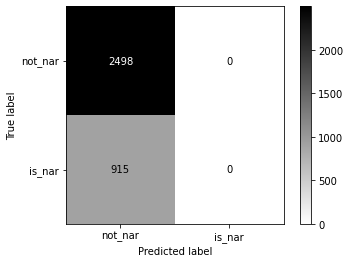

In [70]:
feature_utils.get_prediction_report(flatten(y_test),flatten(pred),crf.classes_)

Split 0
              precision    recall  f1-score   support

      is_nar       0.45      0.20      0.27       781
     not_nar       0.79      0.93      0.86      2597

    accuracy                           0.76      3378
   macro avg       0.62      0.56      0.57      3378
weighted avg       0.72      0.76      0.72      3378

Split 1
              precision    recall  f1-score   support

      is_nar       0.88      0.06      0.11      1045
     not_nar       0.75      1.00      0.85      2911

    accuracy                           0.75      3956
   macro avg       0.81      0.53      0.48      3956
weighted avg       0.78      0.75      0.66      3956

Split 2
              precision    recall  f1-score   support

      is_nar       0.00      0.00      0.00       915
     not_nar       0.73      1.00      0.85      2498

    accuracy                           0.73      3413
   macro avg       0.37      0.50      0.42      3413
weighted avg       0.54      0.73      0.62      3

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Split 3
              precision    recall  f1-score   support

      is_nar       0.00      0.00      0.00      1143
     not_nar       0.72      1.00      0.84      3009

    accuracy                           0.72      4152
   macro avg       0.36      0.50      0.42      4152
weighted avg       0.53      0.72      0.61      4152

Split 4
              precision    recall  f1-score   support

      is_nar       0.00      0.00      0.00      1214
     not_nar       0.68      1.00      0.81      2610

    accuracy                           0.68      3824
   macro avg       0.34      0.50      0.41      3824
weighted avg       0.47      0.68      0.55      3824

Split 5
              precision    recall  f1-score   support

      is_nar       0.00      0.00      0.00      1163
     not_nar       0.72      1.00      0.84      2966

    accuracy                           0.72      4129
   macro avg       0.36      0.50      0.42      4129
weighted avg       0.52      0.72      0.60      4

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Split 6
              precision    recall  f1-score   support

      is_nar       0.00      0.00      0.00       622
     not_nar       0.81      1.00      0.90      2712

    accuracy                           0.81      3334
   macro avg       0.41      0.50      0.45      3334
weighted avg       0.66      0.81      0.73      3334

Split 7
              precision    recall  f1-score   support

      is_nar       0.42      0.05      0.08       911
     not_nar       0.79      0.98      0.87      3304

    accuracy                           0.78      4215
   macro avg       0.60      0.51      0.48      4215
weighted avg       0.71      0.78      0.70      4215

Split 8
              precision    recall  f1-score   support

      is_nar       0.00      0.00      0.00       816
     not_nar       0.82      1.00      0.90      3786

    accuracy                           0.82      4602
   macro avg       0.41      0.50      0.45      4602
weighted avg       0.68      0.82      0.74      4

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Split 9
              precision    recall  f1-score   support

      is_nar       0.59      0.08      0.15      1407
     not_nar       0.64      0.97      0.77      2371

    accuracy                           0.64      3778
   macro avg       0.62      0.52      0.46      3778
weighted avg       0.62      0.64      0.54      3778



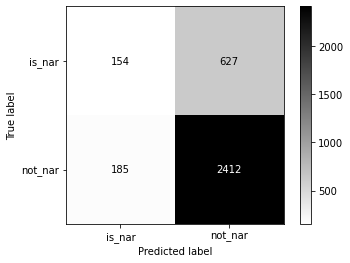

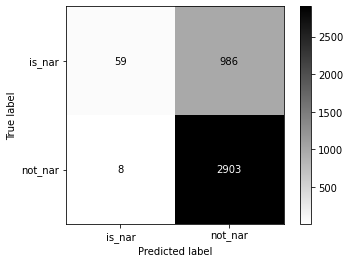

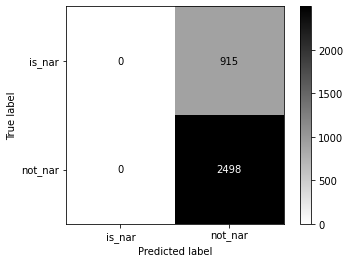

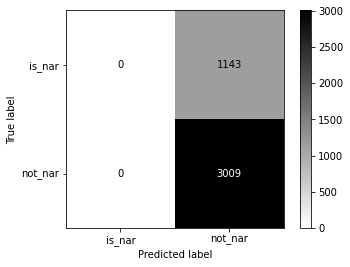

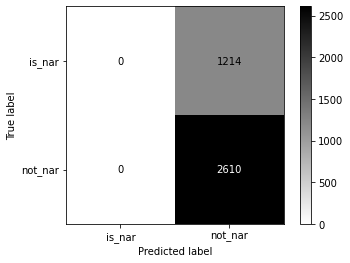

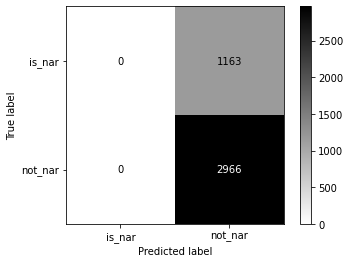

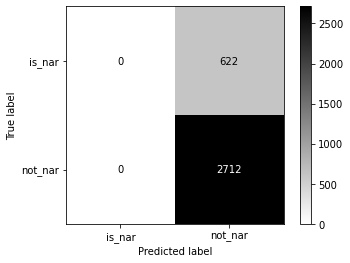

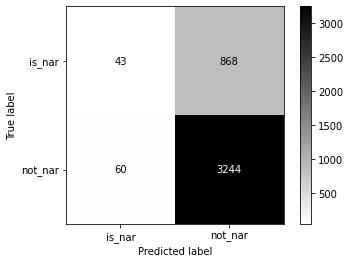

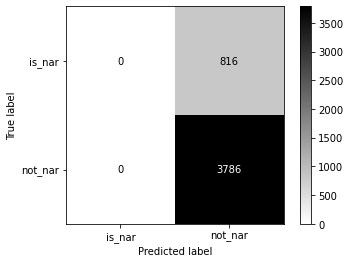

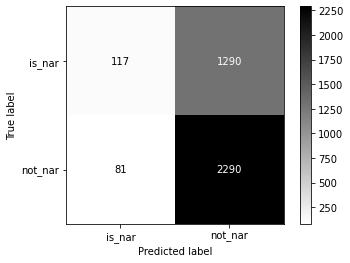

In [49]:
model_utils.get_report_from_splits(ensemble_crf_cv_db,"ens")

In [349]:
sequence_accuracy_score(y_test,ens_crf_pred)

0.872865275142315